### **1. Import necessary libraries and modules**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

from custom_loss_functions import SCCE, SCCEInverse, SCCEMinMaxBin, SCCEMaxBin, SCCEDifference
from custom_layers import DefaultDense, RowWiseQuantized, RowWiseQuantizedSTE, ColumnWiseQuantized, ColumnWiseQuantizedSTE
from custom_callbacks import ScaleTrackingCallback, AccuracyTrackingCallBack, LossTrackingCallbackNew
from utils import print_model_structure, count_unique_values, count_unique_values_and_plot_histograms, count_unique_values_2

from datetime import datetime

from plot_scripts import plot_loss

/Users/anuunchinbat/Desktop/Thesis/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### **2. Import MNIST data:**

In [2]:
# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

### **3. Define model layers**

The custom `RowWiseQuantizedSTE` can be replaced with other custom layer classes. Refer to `custom_layers.py`.

In [3]:
def initialize_quantized_model(input_shape = (28, 28, 1)):
    input_layer = Input(shape=input_shape)
    flatten_layer = Flatten()(input_layer)
    quantized_dense_layer = RowWiseQuantized(128)(flatten_layer)
    quantized_dense_layer_2 = tf.keras.activations.relu(quantized_dense_layer)
    output_layer = RowWiseQuantized(10)(quantized_dense_layer_2)
    output_layer_2 = tf.keras.activations.softmax(output_layer)
    quantized_model = Model(inputs=input_layer, outputs=output_layer_2)

    return quantized_model

### **4. Print model structure for timely inspection**

In [4]:
def prepare_model_dir(model, penalty_rate, run_timestamp):
    log_dir = f'logs/{run_timestamp}_pr_{penalty_rate}'
    os.makedirs(log_dir)
    print_model_structure(model, log_dir, filename="quantized_model_structure.txt")
    return log_dir

### **5. Initialize a custom loss function and compile the model**
The `SCCEMinMaxBin` can be replaced with other loss function objects. Refer to `custom_loss_functions.py`. Note that only `SCCEMinMaxBin` and `SCCEMaxBin` take the `row_wise` argument.

In [5]:
def initialize_loss_function(model, penalty_rate, log_dir, loss_func = SCCEMaxBin):
    # Initialize your custom loss function
    loss_function = loss_func(
        layers=[
            model.get_layer(index=2),
            model.get_layer(index=4)
        ],
        penalty_rate=penalty_rate,
        row_wise=1,
        log_dir = log_dir  # 1 = True = scale factor values are applied row-wise, must match the used custom layer (RowWiseQuantized)
                # 0 = False = scale factor values are applied column-wise, must match the used custom layer (ColumnWiseQuantized)
    )
    return loss_function


def compile_model(model, learning_rate, loss_function):
    # Compile your models
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_function.compute_total_loss,
        metrics=['accuracy']
    )

### **6. Initialize callbacks, train and evaluate the model**

In [6]:
def initialize_callbacks(model, loss_function, log_dir, validation_data):
    # Initialize your callbacks
    scale_tracking_callback_first_dense_layer = ScaleTrackingCallback(model.get_layer(index=2), log_dir)
    scale_tracking_callback_second_dense_layer = ScaleTrackingCallback(model.get_layer(index=4), log_dir)
    penalty_callback = LossTrackingCallbackNew(loss_function=loss_function, validation_data=validation_data, interval=val_interval, log_dir=log_dir)
    accuracy_callback = AccuracyTrackingCallBack(model.get_layer(index=4), log_dir)

    # Return callbacks as a dictionary
    callbacks = {
        'scale_tracking_callback_first_dense_layer': scale_tracking_callback_first_dense_layer,
        'scale_tracking_callback_second_dense_layer': scale_tracking_callback_second_dense_layer,
        'penalty_callback': penalty_callback,
        'accuracy_callback': accuracy_callback
    }

    return callbacks

def train_model(model, epochs, validation_data, batch_size, **callbacks):
    # Train your model
    model.fit(
        x_train, y_train,
        epochs=epochs,
        validation_data=validation_data,
        callbacks=list(callbacks.values()),  
        batch_size=batch_size
    )

def evaluate_model(model):
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f'Quantized Model Test Accuracy: {accuracy}')
    return accuracy


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x30c4c5f10>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x30c4c5c70>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x31893fe50>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x3498b2c40>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x30c48b130>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x30c47b9a0>
  - Input Shape: (None, 10)

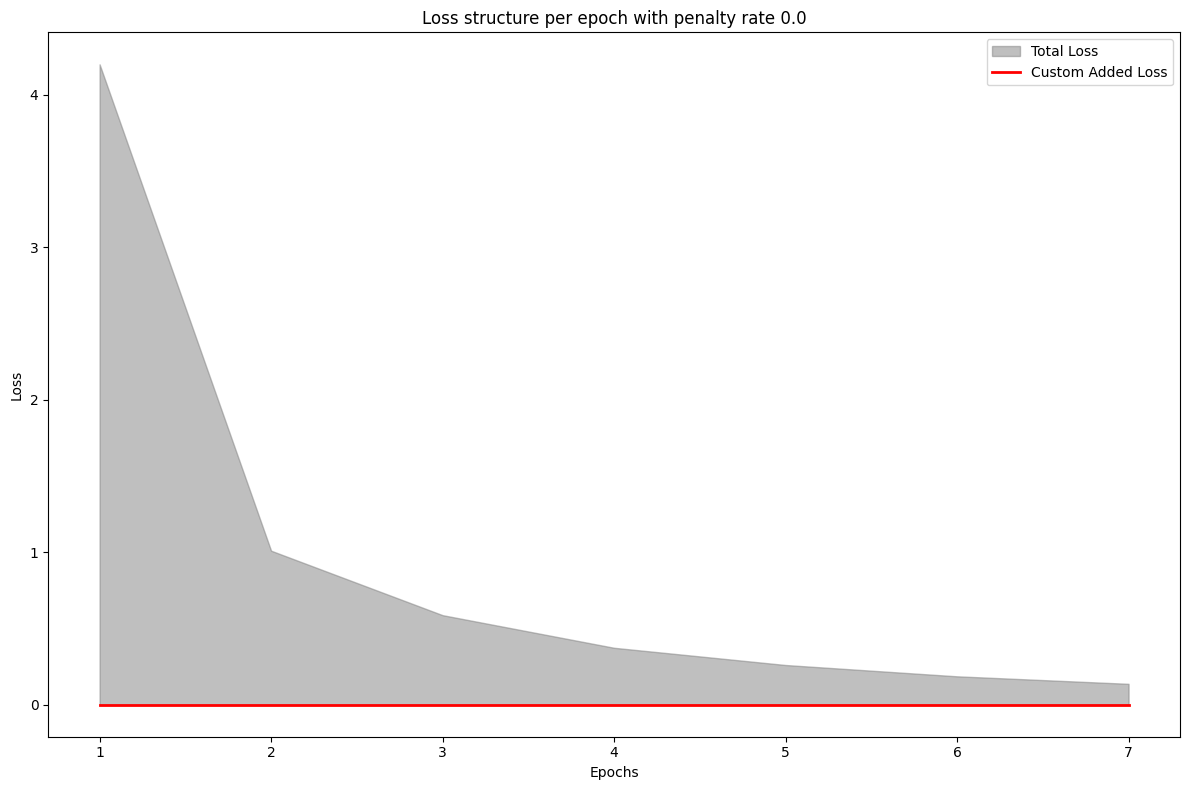


--------------------------------------------------------------------------------
NUMBER OF UNIQUE VALUES FOR W AND B OF EACH CUSTOM LAYER

LAYER WITH ID: 0 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES

LAYER WITH ID: 1 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES

LAYER WITH ID: 2
Unique values in w:  100275
Unique values in quantized w:  19470
Min abs value in quantized w:  0.0
Max abs value in quantized w:  20206.0
The values:  [-20206. -15976. -15947. ...  17321.  17372.  17606.] 

Unique values in b:  128
Unique values in quantized b:  128
Min abs value in quantized b:  42.0
Max abs value in quantized b:  12409.0
The values:  [-12409.  -9234.  -8473.  -8351.  -8054.  -6162.  -5980.  -5942.  -5928.
  -5795.  -5651.  -5549.  -5158.  -5034.  -4716.  -4470.  -4404.  -4237.
  -4232.  -4149.  -3967.  -3780.  -3618.  -3589.  -3517.  -3430.  -3273.
  -3256.  -3250.  -3105.  -3068.  -3063.  -3062.  -3049.  -2847.  -2558.
  -2408.  -2403.  -2288.  -2242.  -2137.  -2104.  -2031

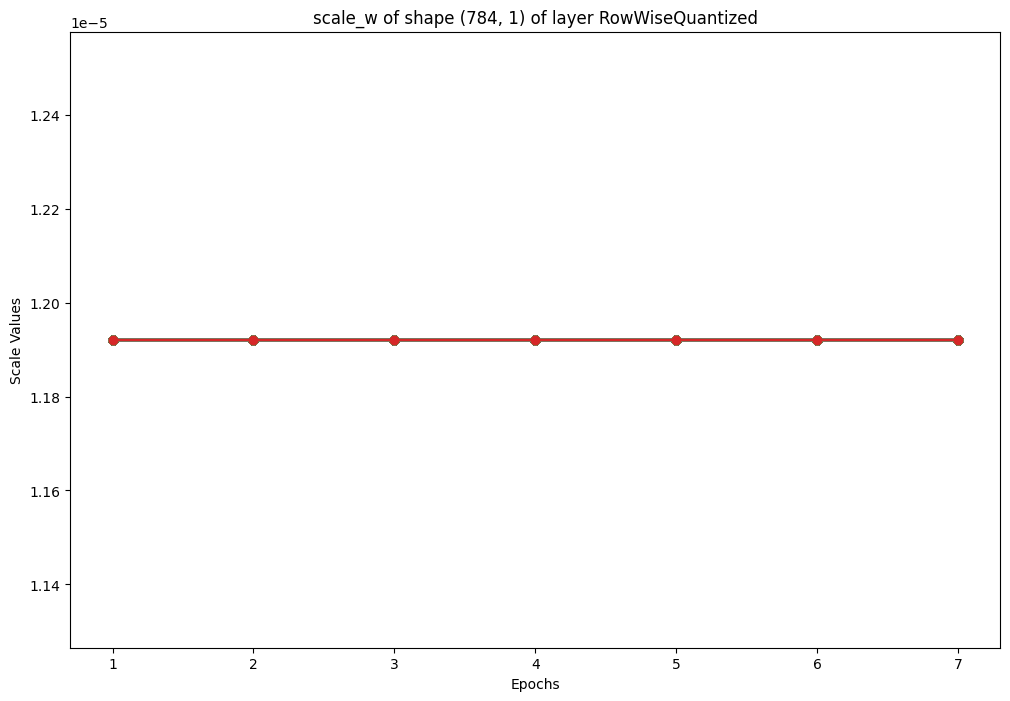

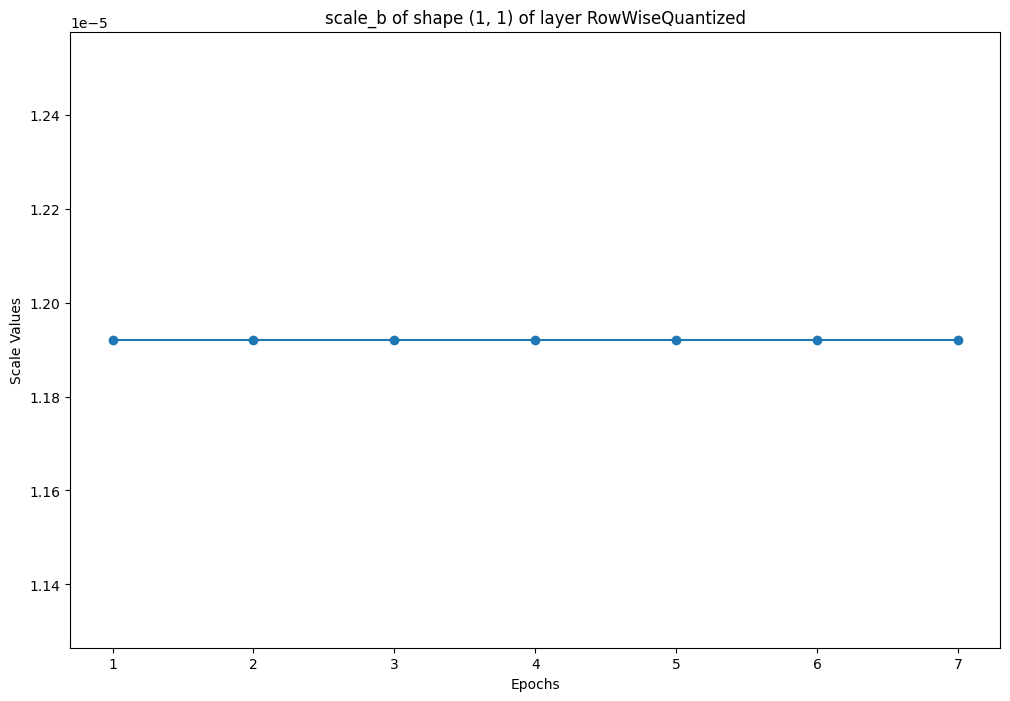

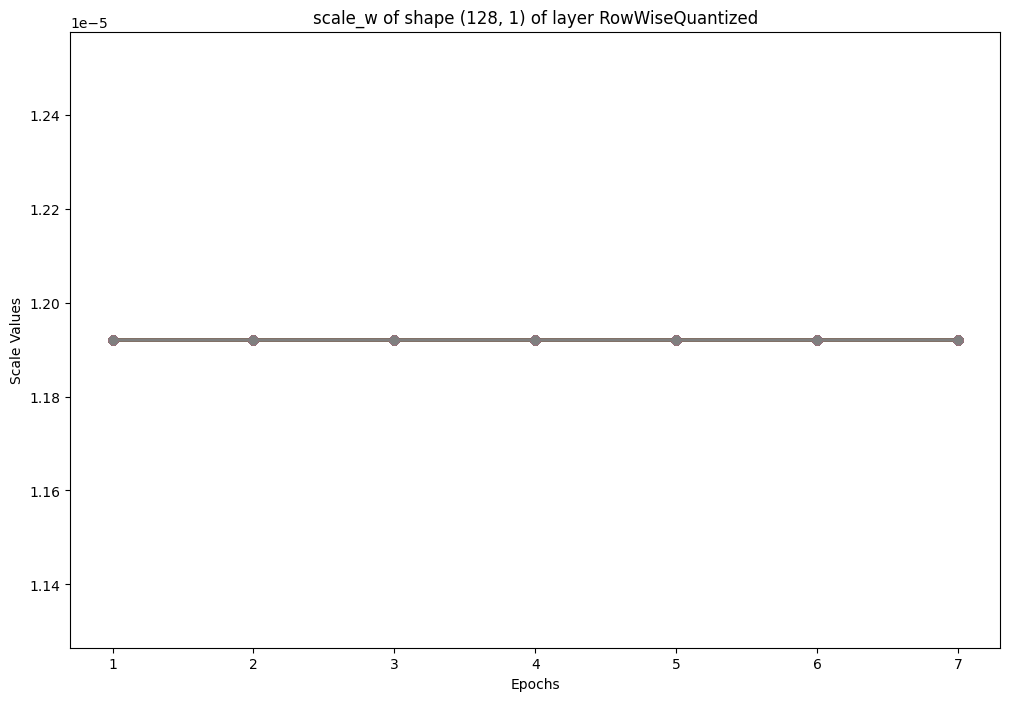

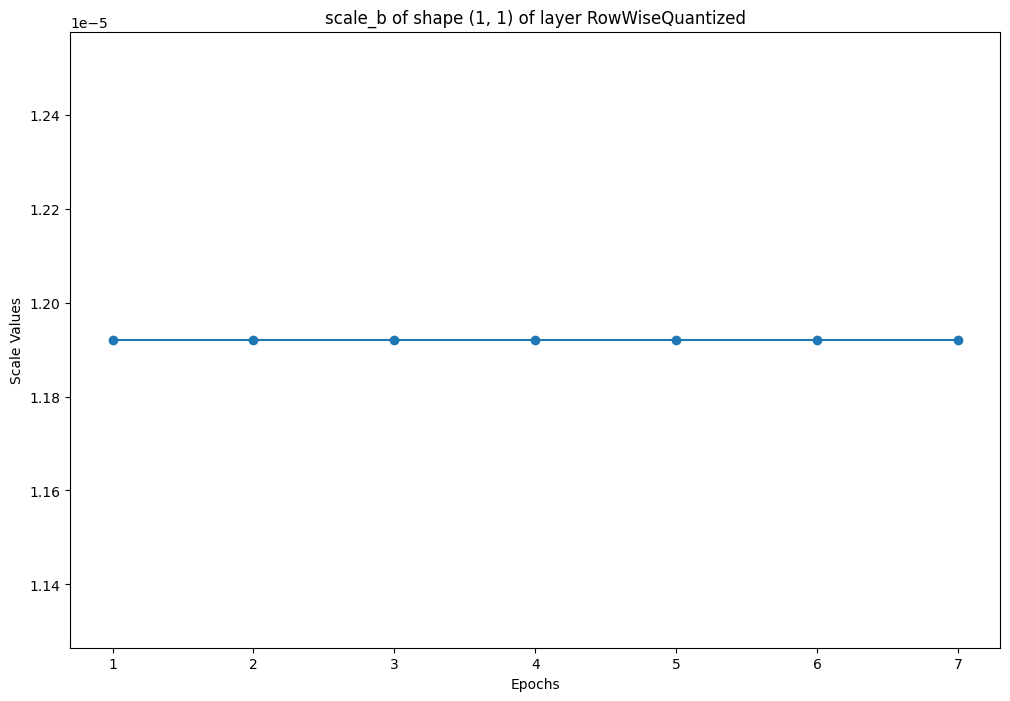

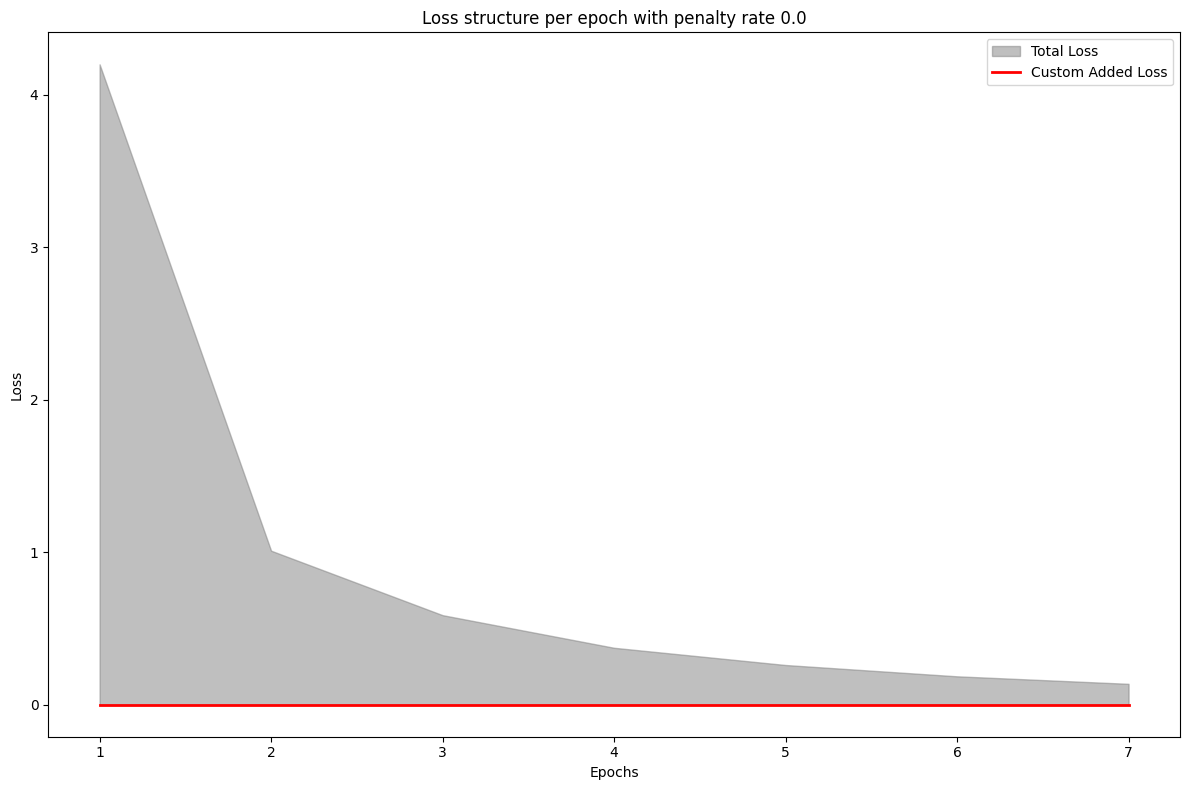

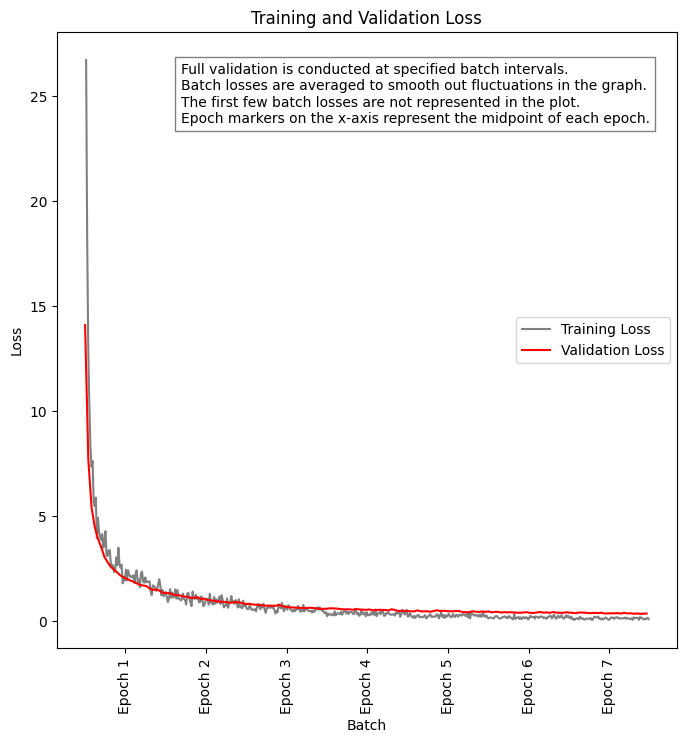


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x30f66de80>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x30f62e970>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x30f052a60>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x30f078b80>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x30f627700>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x30f078e20>
  - Input Shape: (None, 10)

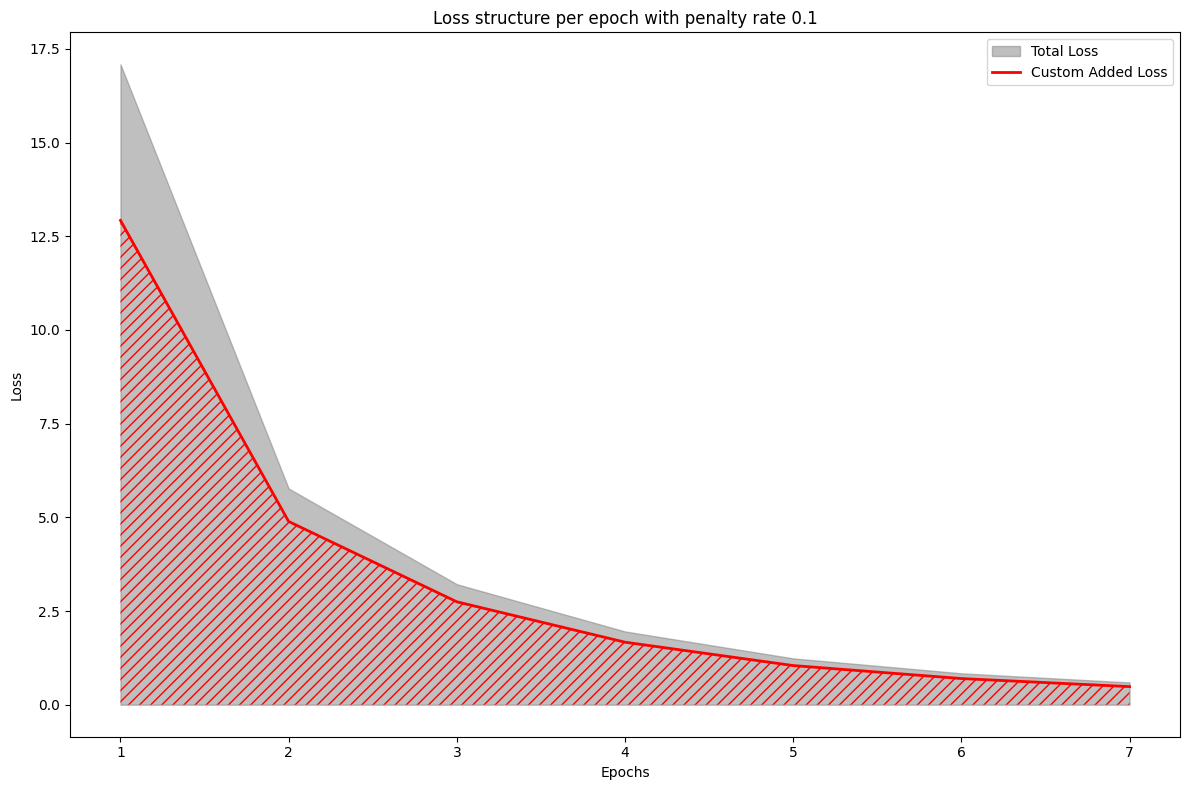


--------------------------------------------------------------------------------
NUMBER OF UNIQUE VALUES FOR W AND B OF EACH CUSTOM LAYER

LAYER WITH ID: 0 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES

LAYER WITH ID: 1 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES

LAYER WITH ID: 2
Unique values in w:  100312
Unique values in quantized w:  22
Min abs value in quantized w:  0.0
Max abs value in quantized w:  11.0
The values:  [-11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.
   3.   4.   5.   6.   7.   8.   9.  10.] 

Unique values in b:  128
Unique values in quantized b:  2
Min abs value in quantized b:  0.0
Max abs value in quantized b:  1.0
The values:  [-1.  0.] 

LAYER WITH ID: 3 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES

LAYER WITH ID: 4
Unique values in w:  1280
Unique values in quantized w:  14
Min abs value in quantized w:  0.0
Max abs value in quantized w:  7.0
The values:  [-7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.] 


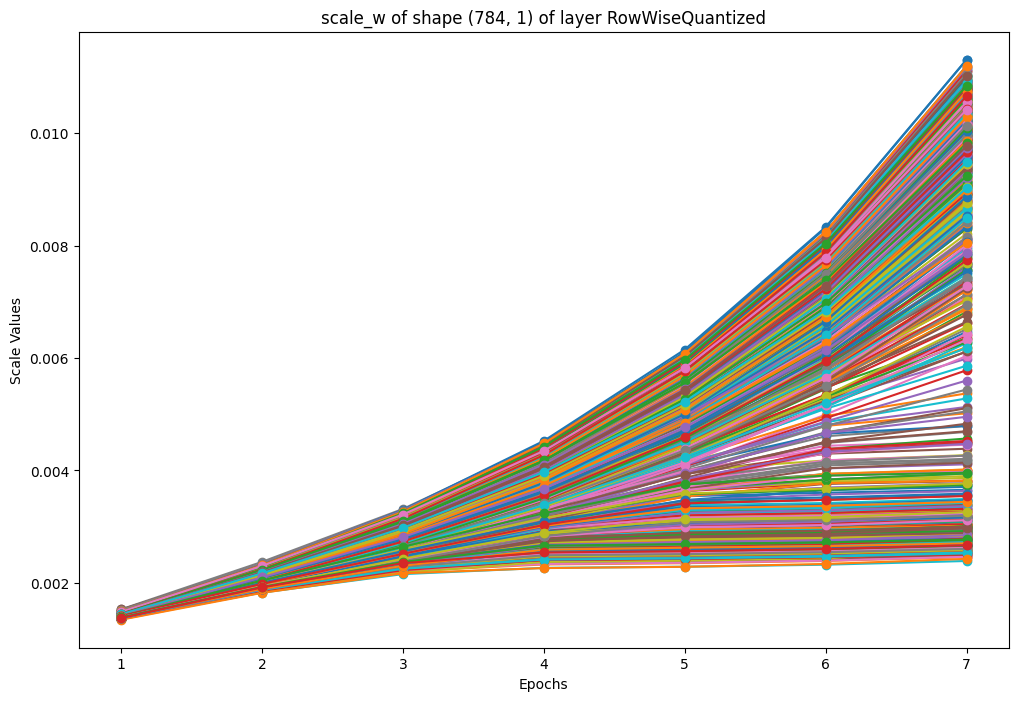

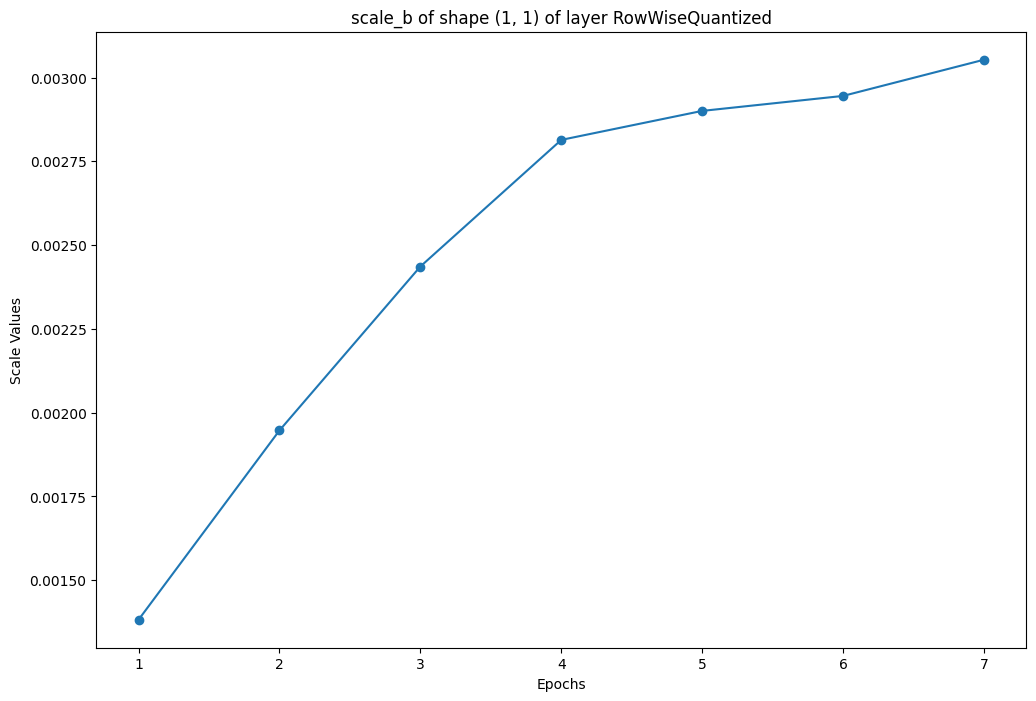

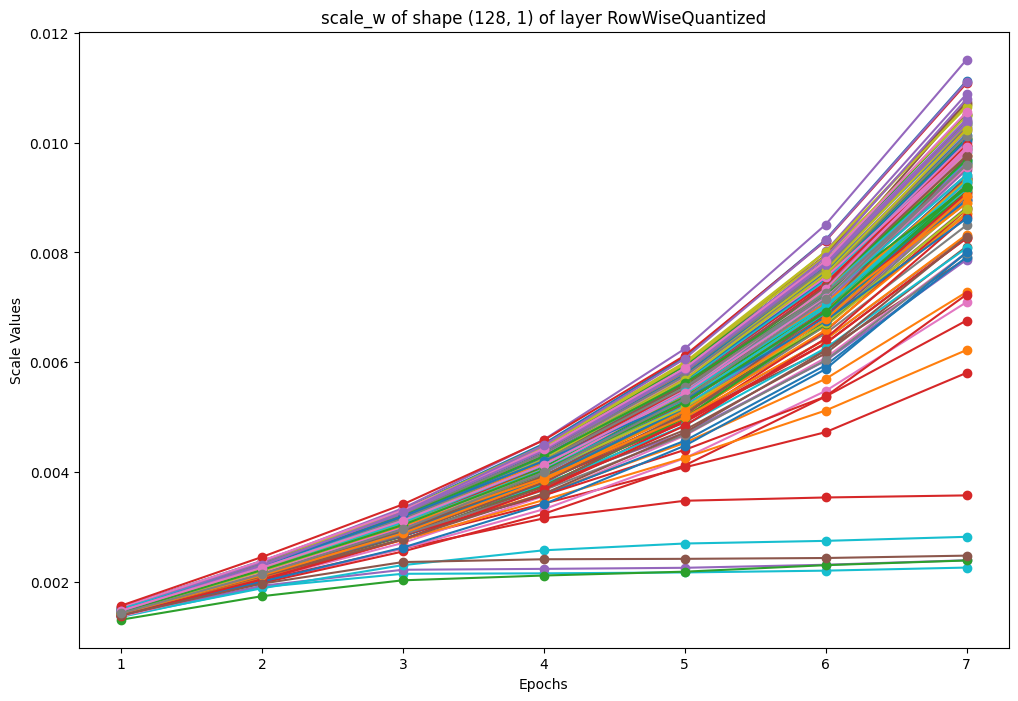

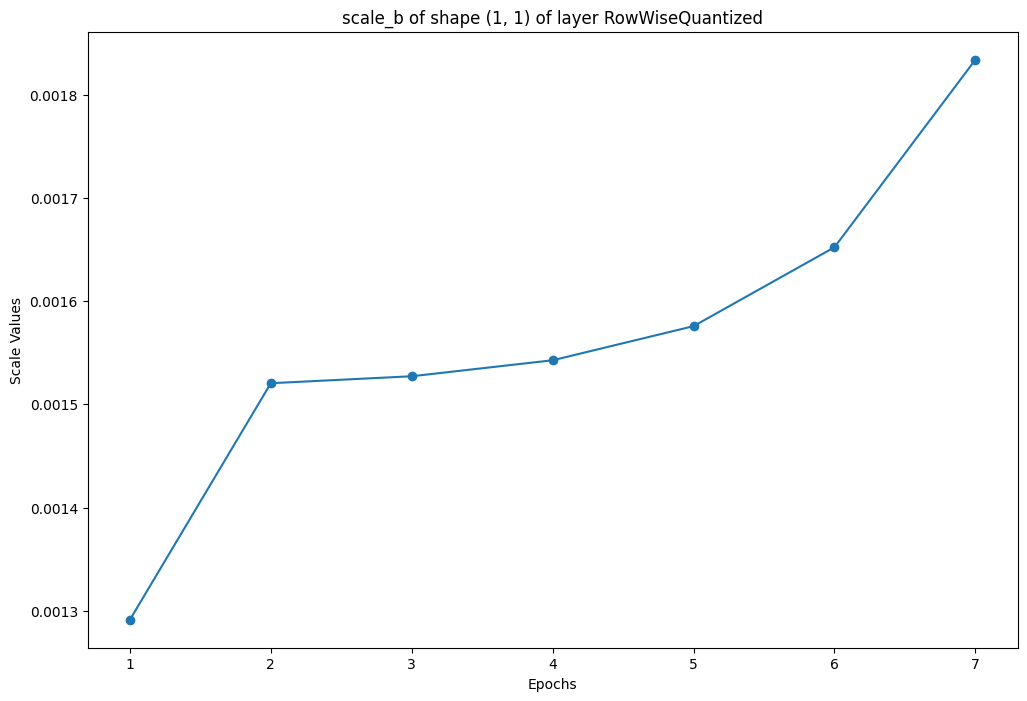

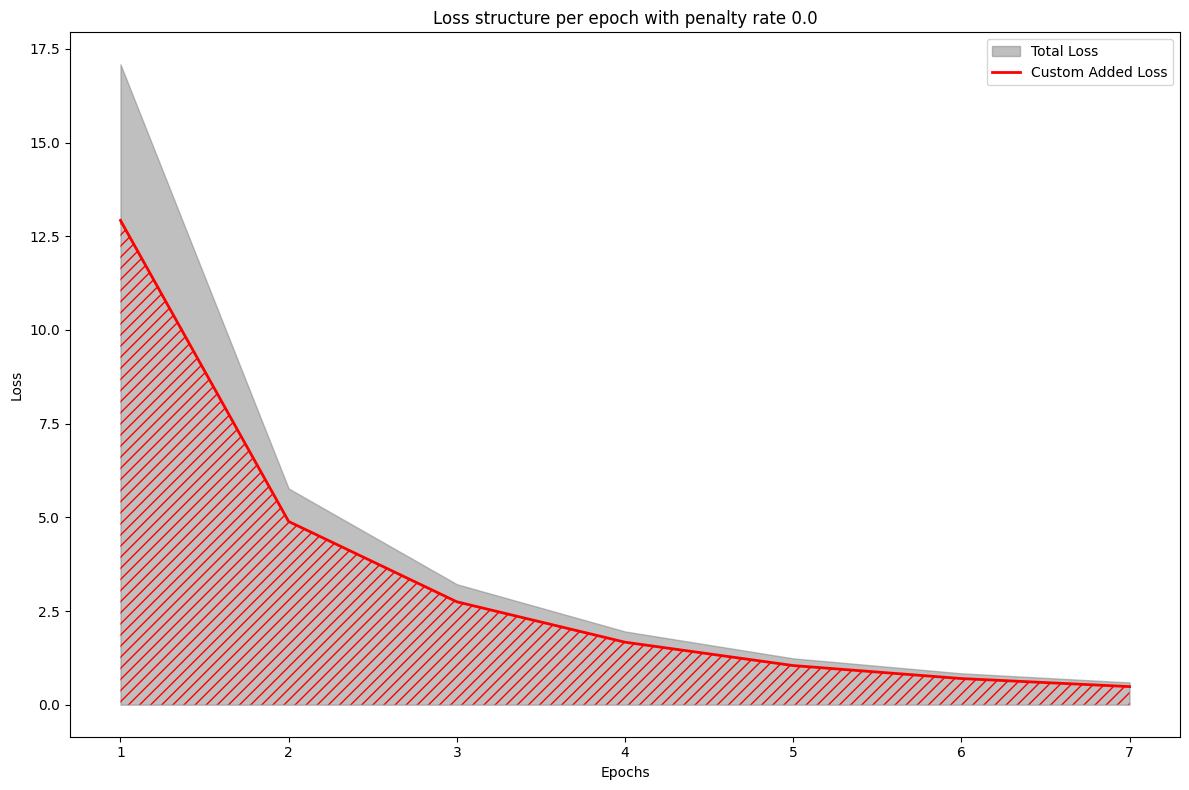

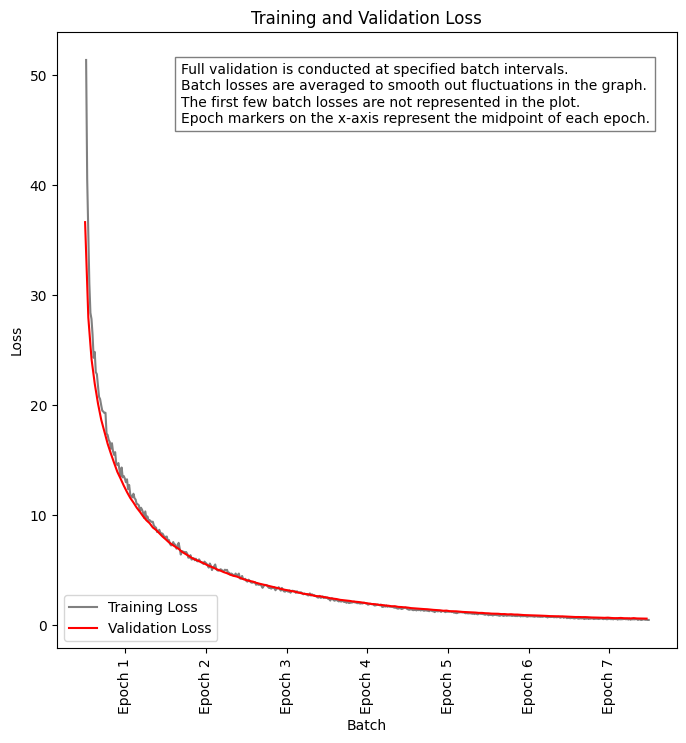

In [17]:
#penalty_rate = [round(x * 0.02 + 0.1, 2) for x in range(45)]
penalty_rates = [
    0.0,
    0.1,
]

learning_rate = 0.0001
validation_data = (x_test, y_test)
epochs = 7
val_interval = 75
batch_size = 32
run_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

log_dirs = []

for pr in penalty_rates:
    
    quantized_model = initialize_quantized_model(input_shape=(28,28,1))

    log_dir = prepare_model_dir(model=quantized_model, penalty_rate=pr, run_timestamp = run_timestamp)
    log_dirs.append(log_dir)

    loss_function = initialize_loss_function(
        model=quantized_model, 
        penalty_rate=pr, 
        log_dir=log_dir
    )

    compile_model(
        model=quantized_model, 
        learning_rate=learning_rate, 
        loss_function=loss_function
    )

    callbacks = initialize_callbacks(
        model=quantized_model, 
        loss_function=loss_function, 
        validation_data=validation_data,
        log_dir=log_dir
    )
    
    train_model(
        model=quantized_model, 
        epochs=epochs, 
        validation_data=validation_data,
        batch_size=batch_size,
        **callbacks
    )

    accuracy = evaluate_model(model=quantized_model)
    plot_loss(log_dir, x_train_size=len(x_train), batch_size=batch_size, penalty_rate=pr)
    count_unique_values(quantized_model,folder_name = log_dir)


    from plot_scripts import plot_training_validation_loss, plot_scale_values, plot_loss, plot_accuracy, plot_unique_values_accuracy

    # Plot scale values of first dense layer
    plot_scale_values(quantized_model.get_layer(index=2), log_dir)
    plot_scale_values(quantized_model.get_layer(index=4), log_dir)
    plot_loss(log_dir, x_train_size=len(x_train), batch_size=batch_size, penalty_rate=penalty_rates[0])
    plot_training_validation_loss(log_dir, interval=val_interval, epochs=epochs, x_train_size=len(x_train), batch_size=batch_size)


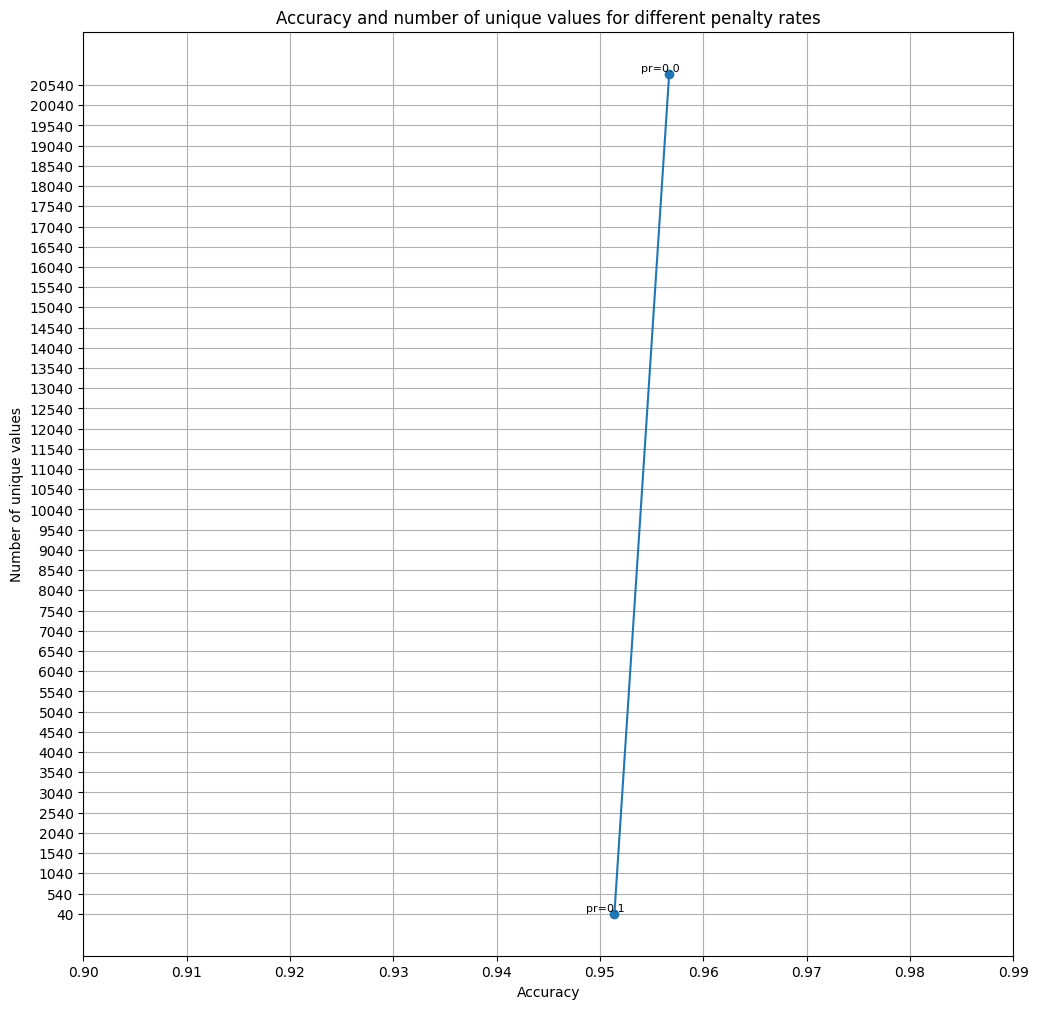

In [23]:
import matplotlib.pyplot as plt

def plot_unique_values_accuracy(log_dirs, penalty_rates):

    def plot(unique_vals, accs, prs):
        plt.figure(figsize=(12, 12))
        plt.plot(accs, unique_vals, marker='o', label="test")
        
        for i, pr in enumerate(prs):
            plt.text(accs[i]+0.001, unique_vals[i] + 0.01, f"pr={pr}", fontsize=8, ha='right', va='bottom')
        
        plt.xticks(np.arange(0.9, 1.0, 0.01))
        plt.yticks(np.arange(min(unique_vals), max(unique_vals) + 2, 500))

        plt.xlabel('Accuracy')
        plt.ylabel('Number of unique values')
        plt.title('Accuracy and number of unique values for different penalty rates')
        plt.grid(True)
        plt.show()

    unique_values_per_pr = []
    accuracies = []

    for log_dir, pr in zip(log_dirs, penalty_rates):
        unique_values_los_path = os.path.join(log_dir, 'unique_values.txt')
        unique_values = 0
        with open(unique_values_los_path, 'r') as f:
            for index, line in enumerate(f):
                if line.startswith("Unique values in quantized"):
                    num = int(line.split()[-1])
                    unique_values += num
        unique_values_per_pr.append(unique_values)

        accuracy_log_path = os.path.join(log_dir, 'accuracy.log')
        last_line = None
        with open(accuracy_log_path, 'r') as f:
            for index, line in enumerate(f):
                last_line = line
        accuracies.append(float(last_line.strip()))

    plot(unique_values_per_pr, accuracies, penalty_rates)

plot_unique_values_accuracy(log_dirs, penalty_rates)
